In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('loandata.csv')
df['fico_score'] = df['fico_score'].astype(int)
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


[58.333,
 73.42699999999999,
 49.585,
 29.158,
 17.696,
 9.524000000000001,
 4.955,
 2.8930000000000002,
 3.2259999999999995]

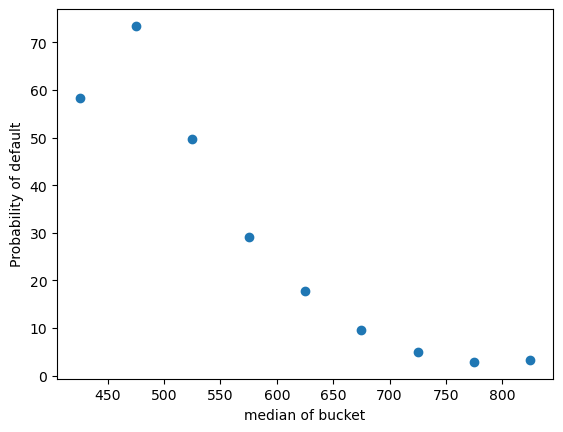

In [63]:

import numpy as np

# to visualise the original distribution of the default odds of data, i will split the set into 8 buckets of range 50
list_prob = []

def get_prob(h_bound: int, l_bound: int): #includes lb, not include hb

    Bucket = df.loc[(df.fico_score > l_bound) & (df.fico_score <= h_bound)]
    tot = Bucket.count().customer_id
    defaults = Bucket.loc[Bucket['default'] == 1].count().customer_id
    prob = defaults / tot
    return prob.round(5)*100


list_prob.append(get_prob(450, 407))
list_prob.append(get_prob(500, 450))
list_prob.append(get_prob(550, 500))
list_prob.append(get_prob(600,550))
list_prob.append(get_prob(650,600))
list_prob.append(get_prob(700,650))
list_prob.append(get_prob(750,700))
list_prob.append(get_prob(800,750))
list_prob.append(get_prob(850,800))


df_prob = {
    "9probs": list_prob,
    "median": np.arange(425,826,50),
}

import seaborn as sns

pd.DataFrame(df_prob)
plt.scatter(y=df_prob['9probs'], x=df_prob['median'])

plt.xlabel('median of bucket')
plt.ylabel('Probability of default')

list_prob # bucket index 8,7,6 can be less than 5% bucket1, index 5,4, can be 15% bucket2, index 3,2 be 40% bucket3 , index 1,0 be 70% bucket4

Aim: 
- set a number of buckets and find boudaries best summarise data.
- create rating map, maps FICO score of borrower to a rating where a lower rating signifies a better credit score.

Process:
- look at how existing credit scores are organised? what different buckets mean in terms of probability default?
- this new rating is solely dependant on FICO

- using Mean Square error: each FICO range should have a percentage of default, so 
    - ideal bucket percentage default --- actual for each range, optimise (miimise error)
    - the optimised range for each bucket percentage of default will be best boundaries.

Process:
- now get randomiser, sample 3 numbers in range 408-850, with a > b > c , for N numer of times. Each time, buckets are generated.
- aim to have bucket 1 in 5%, in bucket 2 = 15%, in bucket 3 = 40%, bucket 4 = 70%

- would be best for randomiser to find the best boundaries one bucket at a time then move onto the next.


In [ ]:

def the_optimisor(P1: int, P2: int, P3: int, P4: int):
    if P1 >= P2 or P2 >= P3 or P3 >= P4:
        return print(" probabilities must satisfy: P1 < P2 < P3 < P4")
    
    boundaries = [850]
    liszt = []
    for i in range(201):
        hb1 = 850
        lb = 850 - i - 1# checks 850 - including 650, i starts from 0, which would not make sense in inequality unless each is shifted by -1
        liszt.append(abs(get_prob(hb1,lb) - P1)) # higher bound is included, lower bound is not included 

    lb1 = 850 - liszt.index(min(liszt)) # since liszt contains elements by index i.
    boundaries.append(lb1)

    hb2 = lb1 - 1
    boundaries.append(hb2)
    # get_prob is 850 >= x > hb2 -1, so hb2 is included in 1st range, so 2nd should start hb2 - 1. 
    #this boundaries [] contains all bounds (included) for all buckets.
    liszt2 = []
    for i in range(201):
        lb = hb2 - i - 1
        liszt2.append(abs(get_prob(hb2,lb) - P2))

    lb2 = hb2 - liszt2.index(min(liszt2))
    boundaries.append(lb2)

    hb3 = lb2 - 1
    boundaries.append(hb3)
    # for this last one we have [hb3, hb4, lb4] 2 intervals to determine, we will have to find a hb4 that maximises closeness of both P3 and P4

    Steps = hb3 - 408 # let hb3 be 450, Steps = 42 range(43): [0, 1, 2 .....41]
    liszt3 = []
    for i in range(Steps):
        lb = hb3 - i - 1 # for lb(408) = 450 - 41 - 1 (must at least leave 408 for last int)
        up_int_Error = abs(get_prob(hb3, lb) - P3) # not including 408, 
        # i=0, hb3 = 450, lb3 = 450 and 449-408, 
        # hb4 =449, lb4 = 408
        low_int_Error = abs(get_prob(lb, 407) - P4)
        liszt3.append((low_int_Error + up_int_Error)/2)
        # i = 42, hb3 = 450, lb3 = 409, hb4 = lb4 = 408

    lb3 = hb3 - liszt3.index(min(liszt3))
    hb4 = lb3 - 1
    boundaries.append(lb3)
    boundaries.append(hb4)
    boundaries.append(408)
        
    return boundaries

[850, 695, 694, 591, 590, 440, 439, 408]

[850, 695, 694, 591, 590, 440, 439, 408]
[4.9910000000000005, 14.948, 39.187, 80.0]


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

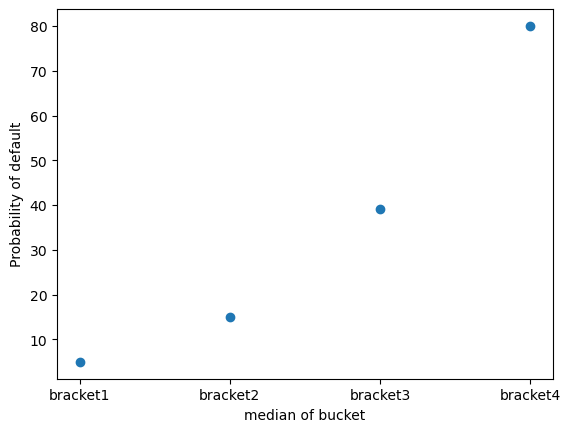

In [ ]:


def buckets_plot_verifier(rom: list):
    ''' plots a graph representing the odds of default and dislays the list containing probability of default for each bucket
    and displays the list of boundaries of the buckets'''
    listrob = []
    listrob.append(get_prob(850,rom[2]))
    listrob.append(get_prob(rom[2],rom[4]))
    listrob.append(get_prob(rom[4],rom[6]))
    listrob.append(get_prob(rom[6],407))


    df_prob = {
        "9probs": listrob,
        "median": ['bracket1','bracket2','bracket3','bracket4']
    }


    pd.DataFrame(df_prob)
    plt.scatter(y=df_prob['9probs'], x=df_prob['median'])

    plt.xlabel('median of bucket')
    plt.ylabel('Probability of default')
    print(rom)
    print(listrob)

    return plt

buckets_plot_verifier(the_optimisor(5,15,40,80))

